In [ ]:
import random

In [ ]:
def lcm(a, b):

    return a * b // xgcd(a,b)[0]

In [ ]:
def xgcd(a, b):

    if a == 0:
        return (b, 0, 1)
    else:
        g, y, x = xgcd(b % a, a)
        return (g, x - (b // a) * y, y)

In [ ]:
def multiplicative_inverse(a, modulus):

    g, x, y = xgcd(a, modulus)
    if g != 1:
        raise Exception('modular inverse does not exist')
    else:
        return x % modulus

In [ ]:
def binary_exponent(base, exponent, modulus):
    
    if modulus == 1:
        yield 0
        return
    bitmask = 1 << exponent.bit_length() - 1
    res = 1
    while bitmask:
        res = (res * res) % modulus
        if bitmask & exponent:
            res = (res * base) % modulus
        yield res
        bitmask >>= 1

In [ ]:
def is_probably_prime(n):
    """
    Check if n is prime or not
    
    """
    tests = max(128, n.bit_length())
    for i in range(tests):
        rand = random.randint(1,n-1)
        return 1 in binary_exponent(rand, n-1, n)

In [ ]:
def generate_prime(bitlen=128):
    """
    generate_prime of length = bitlen
    """
    n = random.getrandbits(bitlen) | 1<<(bitlen-1) | 1
    while not is_probably_prime(n):
        n = random.getrandbits(bitlen) | 1<<(bitlen-1) | 1
    return n

In [ ]:
class PrivateKey:
    """
    attributes:
        λ: lowest common multiple of p-1 and q-1
        μ: modular multiplicative inverse of λ and n
    """
    
    def __init__(self, p, q, n):

        self.λ = lcm( p-1, q-1)
        self.μ = multiplicative_inverse( self.λ, n)
        
    def __repr__(self):
        return ("---\nPrivate Key :\nλ:\t"+str(self.λ) +"\nμ:\t"+str(self.μ) +"\n---")

In [ ]:
class PublicKey:
    """
    attributes:
        n: product of two primes
        g: a random number such that,
    """
    def __init__(self, n):
        self.n = n
        self.nsq = n * n
        self.g = n+1
    
    def __repr__(self):
        return ("---\nPublic Key :\nn:\t"+ str(self.n) +"\n---")

In [ ]:
def generate_keys(bitlen=128):
    
    p = generate_prime(bitlen)
    q = generate_prime(bitlen)
    n = p * q
    return (PublicKey(n), PrivateKey(p, q, n))

In [ ]:
def Encrypt(public_key, plaintext):
    r = random.randint( 1, public_key.n-1)
    while not xgcd( r, public_key.n)[0] == 1:
        r = random.randint( 1, public_key.n)
        
    a = pow(public_key.g, plaintext, public_key.nsq)
    b = pow(r, public_key.n, public_key.nsq)
    
    ciphertext = (a * b) % public_key.nsq
    return ciphertext

In [ ]:
def Decrypt(public_key, private_key, ciphertext):
    x = pow(ciphertext, private_key.λ, public_key.nsq)
    L = lambda x: (x - 1) // public_key.n
    
    plaintext = (L(x) * private_key.μ) % public_key.n 
    return plaintext

In [ ]:
def homomorphic_add(public_key, a, b):
    return (a * b) % public_key.nsq


def homomorphic_add_constant(public_key, a, k):
    return a * pow( public_key.g, k, public_key.nsq) % public_key.nsq


def homomorphic_mult_constant(public_key, a, k):
    return pow(a, k, public_key.nsq)

In [ ]:
from PIL import Image
import numpy as np
import pickle
import cv2

def image_encryption(public_key, plain_image):
  
    cipher_image = np.asarray(plain_image)
    shape = cipher_image.shape
    cipher_image = cipher_image.flatten().tolist()
    cipher_image = [Encrypt(public_key, pix) for pix in cipher_image]
    
    return np.asarray(cipher_image).reshape(shape)


def image_decryption(public_key, private_key, cipher_image):
    
    shape = cipher_image.shape
    plain_image = cipher_image.flatten().tolist()
    plain_image = [Decrypt(public_key, private_key, pix) for pix in plain_image]
    plain_image = [pix if pix < 255 else 255 for pix in plain_image]
    plain_image = [pix if pix > 0 else 0 for pix in plain_image]
    
    return Image.fromarray(np.asarray(plain_image).reshape(shape).astype(np.uint8))


def increase_brightness(public_key, cipher_image, factor):
   
    shape = cipher_image.shape
    brightend_image = cipher_image.flatten().tolist()
    brightend_image = [homomorphic_add_constant(public_key, pix, factor) for pix in brightend_image]
    
    return np.asarray(brightend_image).reshape(shape)


def show_encrypted_image(cipher_image):
    
    for i in range(0,cipher_image.shape[0]):
        for j in range(0,cipher_image.shape[1]):
            for k in range(0,3):
                cipher_image[i][j][k] = cipher_image[i][j][k]%256

    cipher_image = cipher_image.astype(np.uint8)
    im = Image.fromarray(cipher_image)
    im.save("encrypted_image.png")
    im.show()


    # filename = "encrypted-images/" + filename
    # fstream = open(filename, "wb")
    # pickle.dump(cipher_image, fstream)
    # fstream.close()


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving download.jpg to download.jpg


---
Public Key :
n:	69218236804235467126087093861788398471836399435690476607581146673125582587487
---


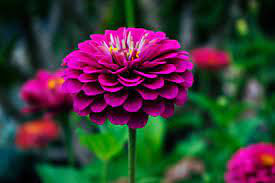

In [ ]:
from doctest import OutputChecker
from PIL import Image
import numpy as np


publickey, privatekey = generate_keys()
print(publickey.__repr__())

im = Image.open(r"download.jpg") 
im.show()

encrypt_image = image_encryption(publickey,im)

In [ ]:
encrypt_image.shape

(183, 275, 3)

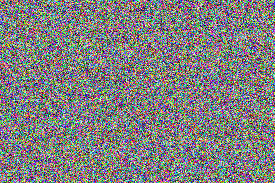

In [ ]:
enc_img=show_encrypted_image(encrypt_image)

In [ ]:
import matplotlib.pyplot as plt
img = plt.imread("encrypted_image.png")
gray = np.mean(img, axis=-1)

threshold = 0.5
binary = (gray > threshold).astype(np.uint8) * 1

img_array = np.array(binary)
img_array

array([[0, 1, 1, ..., 1, 1, 0],
       [0, 1, 1, ..., 1, 1, 1],
       [1, 0, 0, ..., 1, 1, 0],
       ...,
       [0, 1, 1, ..., 0, 1, 1],
       [1, 1, 1, ..., 1, 0, 1],
       [0, 1, 1, ..., 1, 0, 1]], dtype=uint8)

In [ ]:
img_array.shape

(183, 275)

In [ ]:
def encode_message(bits, bases):
    message = []
    for i in range(n):
        qc = QuantumCircuit(1,1)
        if bases[i] == 0: # Prepare qubit in Z-basis
            if bits[i] == 0:
                pass 
            else:
                qc.x(0)
        else: # Prepare qubit in X-basis
            if bits[i] == 0:
                qc.h(0)
            else:
                qc.x(0)
                qc.h(0)
        qc.barrier()
        message.append(qc)
    return message